# Comparative Analysis of Image classification models using Machine Learning and CNN

## Data Preparation

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

from pathlib import Path

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

#### Suppressing warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Defining paths to image dataset folder

In [3]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

### Creating Training dataframe

In [4]:
# Get the path to the normal and pneumonia sub-directories
train_normal_cases_dir = train_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in train_pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# train_data = train_data.sample(frac=1., random_state=0).reset_index(drop=True)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\PNEUMONIA\person1455_virus_24...,1
1,chest_xray\train\PNEUMONIA\person475_bacteria_...,1
2,chest_xray\train\PNEUMONIA\person24_bacteria_1...,1
3,chest_xray\train\PNEUMONIA\person20_bacteria_6...,1
4,chest_xray\train\PNEUMONIA\person53_bacteria_2...,1


### Creating Testing dataframe

In [5]:
# Get the path to the normal and pneumonia sub-directories
test_normal_cases_dir = test_dir / 'NORMAL'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# test_data = test_data.sample(frac=1., random_state=0).reset_index(drop=True)
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,chest_xray\test\NORMAL\IM-0009-0001.jpeg,0
1,chest_xray\test\PNEUMONIA\person1640_virus_283...,1
2,chest_xray\test\NORMAL\NORMAL2-IM-0275-0001.jpeg,0
3,chest_xray\test\NORMAL\IM-0017-0001.jpeg,0
4,chest_xray\test\NORMAL\NORMAL2-IM-0146-0001.jpeg,0


<hr>

## Exploratory Data Analysis

### Displaying 5 Pneumonia and Normal case images each

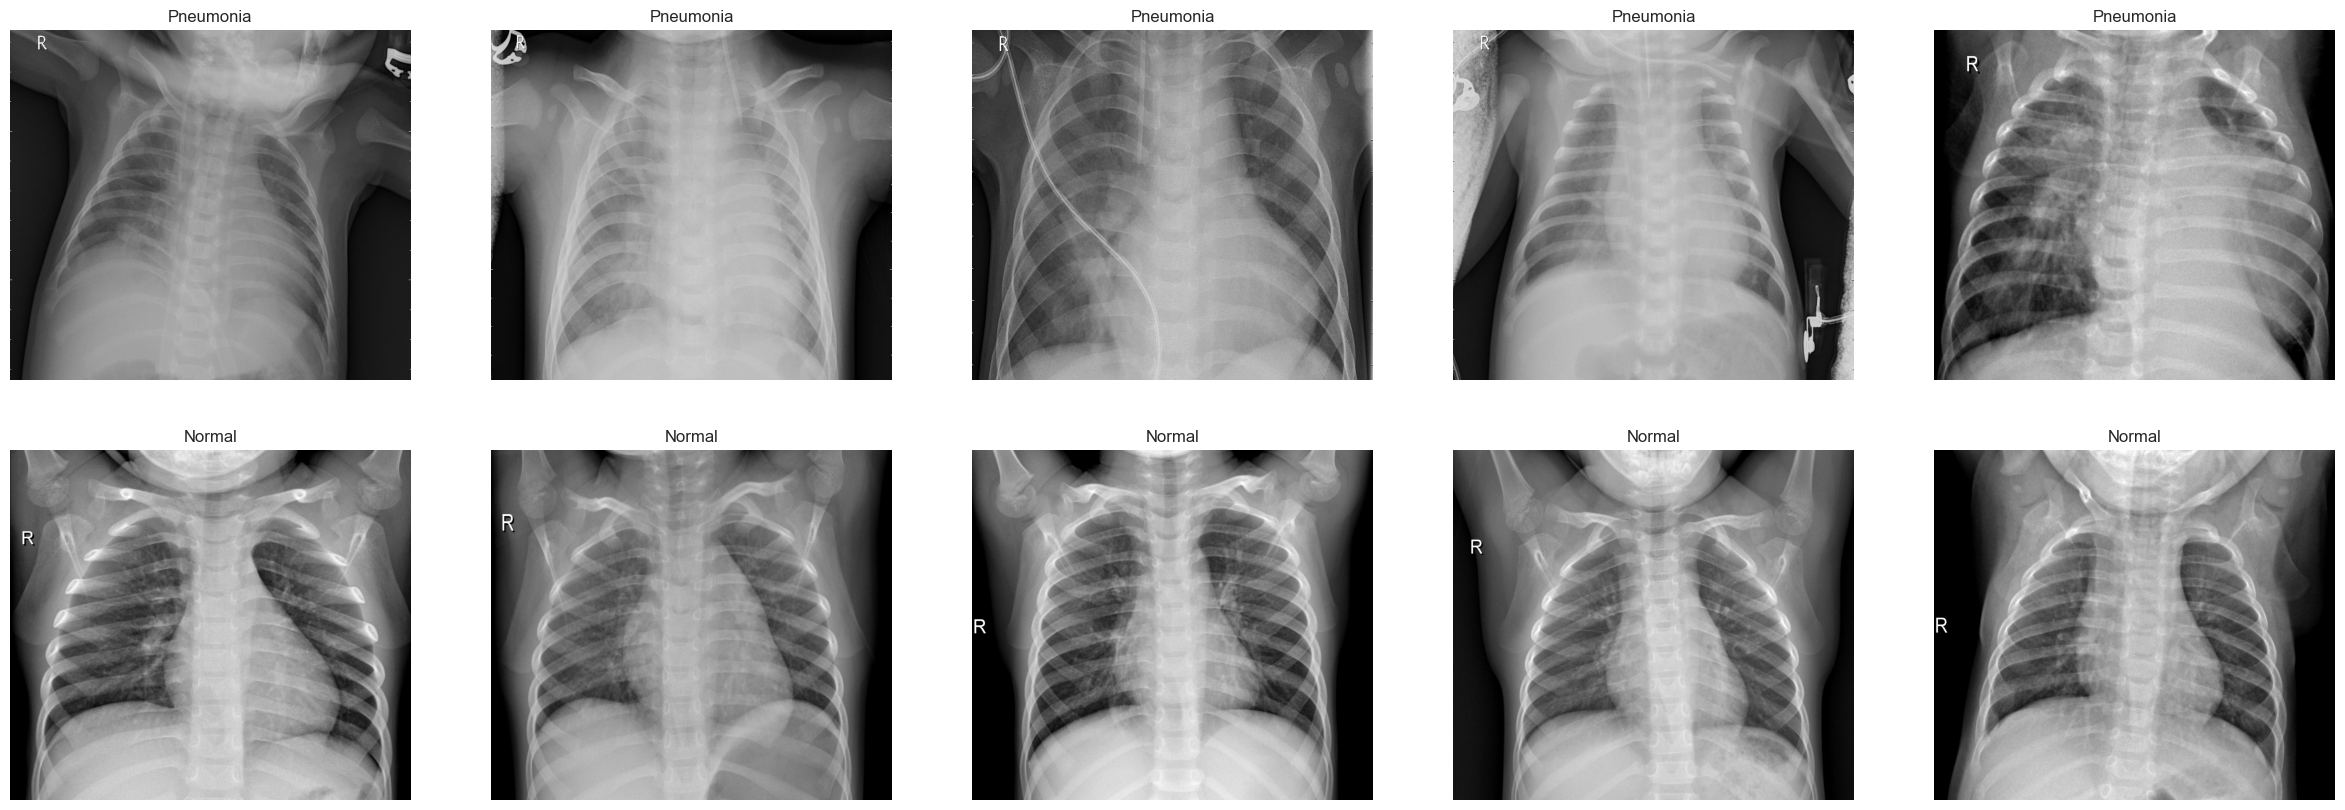

In [6]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Checking the Class distribution

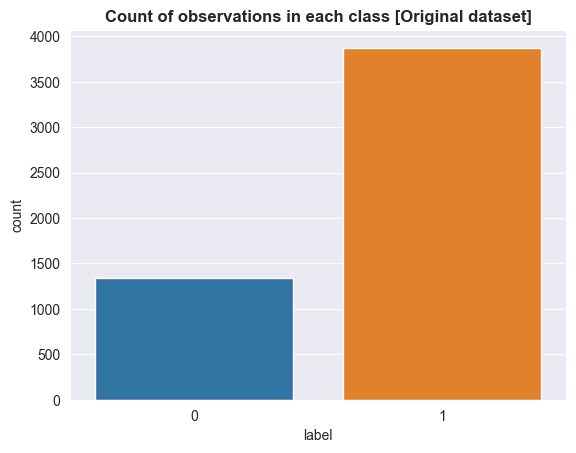

In [7]:
sns.countplot(data=train_data, x='label')

plt.title("Count of observations in each class [Original dataset]", fontweight='bold')
plt.show()

#### Inference
1. Our dataset is unbalanced. We have much lesser normal cases that pneumonia cases. 
2. We will calculate the number of normal cases and take the same number of normal and pneumonia cases

In [8]:
# Finding number of observations in test dataset
len(train_data[train_data['label']==0])

1341

#### Balancing Class distribution
We will take 1300 observations from both classes

In [9]:
train_data_balanced = []

for img in train_data[train_data['label']==1][:1300]['image']:
    train_data_balanced.append((img,1))

for img in train_data[train_data['label']==0][:1300]['image']:
    train_data_balanced.append((img,0))

# Get a pandas dataframe from the data we have in our list 
train_data_balanced = pd.DataFrame(train_data_balanced, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data_balanced = train_data_balanced.sample(frac=1., random_state=0).reset_index(drop=True)

# How the dataframe looks like?
train_data_balanced.head()

,image,label
0,chest_xray\train\PNEUMONIA\person1408_bacteria...,1
1,chest_xray\train\NORMAL\IM-0231-0001.jpeg,0
2,chest_xray\train\NORMAL\IM-0467-0001-0001.jpeg,0
3,chest_xray\train\PNEUMONIA\person662_bacteria_...,1
4,chest_xray\train\NORMAL\NORMAL2-IM-1064-0001.jpeg,0


#### Comparing count of Original and Balanced training dataset

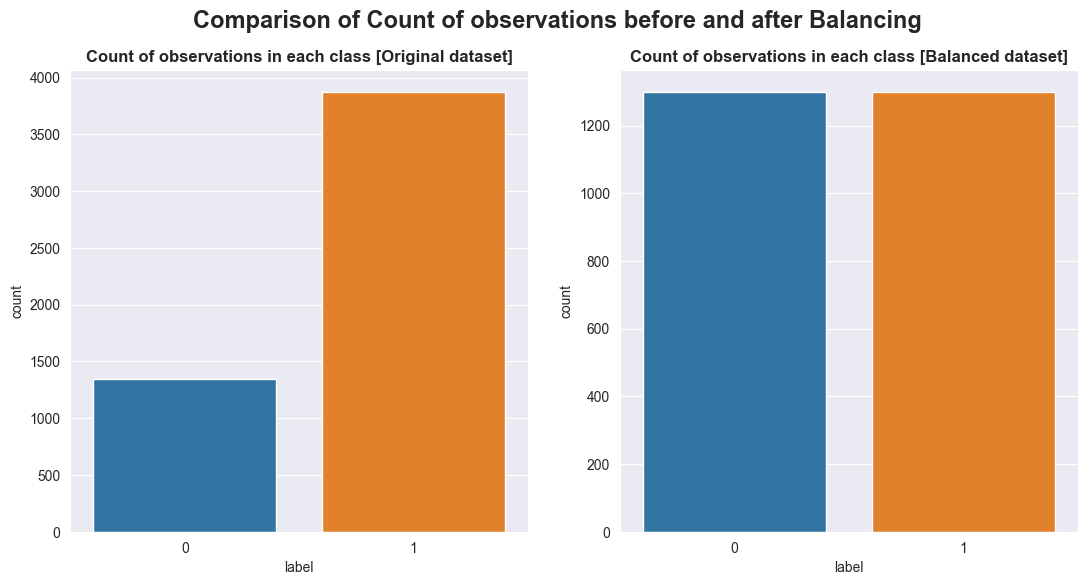

In [10]:
fig = plt.figure(figsize=(13,6))

# Original countplot
plt.subplot(1,2,1)
sns.countplot(data=train_data, x='label')

plt.title("Count of observations in each class [Original dataset]", fontweight='bold')

# Balanced countplot
plt.subplot(1,2,2)
sns.countplot(data=train_data_balanced, x='label')

plt.title("Count of observations in each class [Balanced dataset]", fontweight='bold')

fig.suptitle("Comparison of Count of observations before and after Balancing", fontweight='bold', fontsize=17)
fig.show()

## Inferring useful columns

### Finding the size of each image

In [11]:
sizes = []
for imgPath in train_data_balanced['image']:
    img = imread(imgPath)
    size = img.shape
    sizes.append(size)

train_data_balanced['size'] = sizes
train_data_balanced

,image,label,size
0,chest_xray\train\PNEUMONIA\person1408_bacteria...,1,"(1288, 1576)"
1,chest_xray\train\NORMAL\IM-0231-0001.jpeg,0,"(1437, 1650)"
2,chest_xray\train\NORMAL\IM-0467-0001-0001.jpeg,0,"(1739, 1912)"
3,chest_xray\train\PNEUMONIA\person662_bacteria_...,1,"(656, 928)"
4,chest_xray\train\NORMAL\NORMAL2-IM-1064-0001.jpeg,0,"(1552, 1880)"
...,...,...,...
2595,chest_xray\train\PNEUMONIA\person1591_bacteria...,1,"(664, 1160)"
2596,chest_xray\train\NORMAL\IM-0451-0001.jpeg,0,"(1746, 1850)"
2597,chest_xray\train\PNEUMONIA\person1619_bacteria...,1,"(1040, 1400)"
2598,chest_xray\train\PNEUMONIA\person877_bacteria_...,1,"(664, 1056)"


### Calculating the image size ratios and vector length of all images

In [12]:
ratios = []
lengths = []
for size in train_data_balanced['size']:
  length = size[1] * size[0]
  ratio = size[1] / size[0]
  lengths.append(length)
  ratios.append(ratio)

train_data_balanced['length'] = lengths
train_data_balanced['ratio'] = ratios
train_data_balanced

,image,label,size,length,ratio
0,chest_xray\train\PNEUMONIA\person1408_bacteria...,1,"(1288, 1576)",2029888,1.223602
1,chest_xray\train\NORMAL\IM-0231-0001.jpeg,0,"(1437, 1650)",2371050,1.148225
2,chest_xray\train\NORMAL\IM-0467-0001-0001.jpeg,0,"(1739, 1912)",3324968,1.099482
3,chest_xray\train\PNEUMONIA\person662_bacteria_...,1,"(656, 928)",608768,1.414634
4,chest_xray\train\NORMAL\NORMAL2-IM-1064-0001.jpeg,0,"(1552, 1880)",2917760,1.211340
...,...,...,...,...,...
2595,chest_xray\train\PNEUMONIA\person1591_bacteria...,1,"(664, 1160)",770240,1.746988
2596,chest_xray\train\NORMAL\IM-0451-0001.jpeg,0,"(1746, 1850)",3230100,1.059565
2597,chest_xray\train\PNEUMONIA\person1619_bacteria...,1,"(1040, 1400)",1456000,1.346154
2598,chest_xray\train\PNEUMONIA\person877_bacteria_...,1,"(664, 1056)",701184,1.590361


### Exploring the balanced dataset with additional inferred columns

In [13]:
train_data_balanced.describe()

,label,length,ratio
count,2600.000000,2.600000e+03,2600.000000
mean,0.500000,1.722198e+06,1.370678
std,0.500096,1.061899e+06,0.243158
min,0.000000,6.543600e+04,0.877220
25%,0.000000,8.970720e+05,1.201629
50%,0.500000,1.555328e+06,1.330157
75%,1.000000,2.250650e+06,1.494633
max,1.000000,7.532028e+06,2.957055


#### Visualizing the distribution of vector lengths of all images

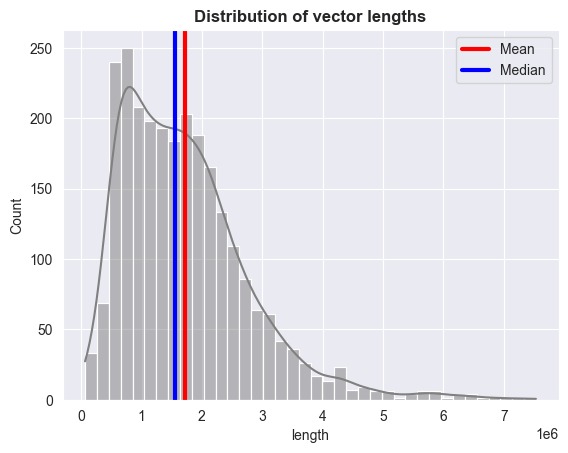

In [14]:
sns.histplot(data=train_data_balanced, x='length', color='gray', kde=True)
plt.axvline(train_data_balanced['length'].mean(), color='red', lw=3, label="Mean")
plt.axvline(train_data_balanced['length'].median(), color='blue', lw=3, label="Median")

plt.title("Distribution of vector lengths", fontweight='bold')
plt.legend()
plt.show()

We will resize all images to the mean size

In [15]:
length = train_data_balanced['length'].min()
print(length)

# We will resize all images into x*x images
x = int(np.sqrt(length))
x

65436


255

<hr>

## Machine Learning Models

##### Function to create the image dataset to be used in Machine Learning model

In [16]:
def makeDataset(data):
    dataset = ""
    for location in data:
        # reading the image from location
        img = imread(location)
        
        # turning rgb images to grayscale
        if len(img.shape) == 3:
            img = rgb2gray(img)

        # resizing to our desired size and scaling it to 255
        img = resize(img, (x, x), anti_aliasing=True) * 255

        # converting to uint8 for saving memory
        img = img.astype(np.uint8)

        # converting to vector
        img = img.reshape(-1)

        # initiating dataset or vstacking onto dataset
        if type(dataset) == str:
            dataset = img
        else:
            dataset = np.vstack([dataset, img])

    # returning dataset
    return dataset

##### Function to create the training and testing datasets

In [17]:
def train_test_split(train, test, train_size=500, test_proportion=0.2):
    test_size = int(test_proportion * train_size)

    X_train = makeDataset(train['image'][:train_size])
    y_train = train['label'][:train_size]
    X_test = makeDataset(test['image'][:test_size])
    y_test = test['label'][:test_size]
    
    return (X_train, X_test, y_train, y_test)

##### Function to perform LDA on the image dataset

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def doLDA(X_train, y_train, X_test):
    lda = LDA()
    lda.fit(X_train, y_train)
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)
    
    return(X_train_lda, X_test_lda)

##### Dictionary that holds the model objects for each type of ML Classifier

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(gamma='auto'),
    "Gaussian Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=2)
}

### Fitting and Comparing different Machine Learning models

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Dictionary to hold the accuracy metrics
ml_metrics = {
    "Classifier": [],
    "Test Proportion": [],
    "Accuracy (without LDA)": [],
    "Confusion Matrix (without LDA)": [],
    "Accuracy (with LDA)": [],
    "Confusion Matrix (with LDA)": []
}

# Looping through different test proportions
for test_proportion in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:

    # Looping through different ML models
    for name, clf in classifiers.items():    
        ml_metrics['Classifier'].append(name)
        ml_metrics["Test Proportion"].append(test_proportion)
        
        # Creating train and test dataset and performing LDA
        X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, test_data, test_proportion=test_proportion)
        X_train_lda, X_test_lda = doLDA(X_train, y_train, X_test)

        # Fitting model to LDA dataset
        clf.fit(X_train_lda, y_train)
        y_pred = clf.predict(X_test_lda)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        ml_metrics['Accuracy (with LDA)'].append(np.round(acc, decimals=3))
        ml_metrics['Confusion Matrix (with LDA)'].append(cm)

        # Fitting model to non-LDA dataset
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        ml_metrics['Accuracy (without LDA)'].append(np.round(acc, decimals=3))
        ml_metrics['Confusion Matrix (without LDA)'].append(cm)
        
    # Printing confirmation after each test proportion
    print(f"Done for test proportion {test_proportion}")

# Converting metrics dictionary into dataframe and displaying
ml_metrics= pd.DataFrame(ml_metrics)
ml_metrics = ml_metrics.sort_values(['Classifier', 'Test Proportion']).reset_index(drop=True)
ml_metrics

Done for test proportion 0.1
Done for test proportion 0.15
Done for test proportion 0.2
Done for test proportion 0.25
Done for test proportion 0.3
Done for test proportion 0.35


,Classifier,Test Proportion,Accuracy (without LDA),Confusion Matrix (without LDA),Accuracy (with LDA),Confusion Matrix (with LDA)
0,Decision Tree,0.10,0.680,"[[12, 12], [4, 22]]",0.700,"[[9, 15], [0, 26]]"
1,Decision Tree,0.15,0.680,"[[14, 16], [8, 37]]",0.693,"[[10, 20], [3, 42]]"
2,Decision Tree,0.20,0.680,"[[18, 20], [12, 50]]",0.710,"[[12, 26], [3, 59]]"
3,Decision Tree,0.25,0.672,"[[22, 26], [15, 62]]",0.720,"[[17, 31], [4, 73]]"
4,Decision Tree,0.30,0.667,"[[22, 34], [16, 78]]",0.720,"[[18, 38], [4, 90]]"
5,Decision Tree,0.35,0.686,"[[24, 41], [14, 96]]",0.709,"[[19, 46], [5, 105]]"
6,Gaussian Naive Bayes,0.10,0.680,"[[16, 8], [8, 18]]",0.680,"[[9, 15], [1, 25]]"
7,Gaussian Naive Bayes,0.15,0.680,"[[19, 11], [13, 32]]",0.720,"[[11, 19], [2, 43]]"
8,Gaussian Naive Bayes,0.20,0.650,"[[25, 13], [22, 40]]",0.730,"[[13, 25], [2, 60]]"
9,Gaussian Naive Bayes,0.25,0.656,"[[32, 16], [27, 50]]",0.744,"[[18, 30], [2, 75]]"


#### Exporting ML accuracy metrics to external csv file

In [21]:
ml_metrics.to_csv("Machine_Learning_Metrics.csv", index=False)

### Visualizing Accuracy Metrics

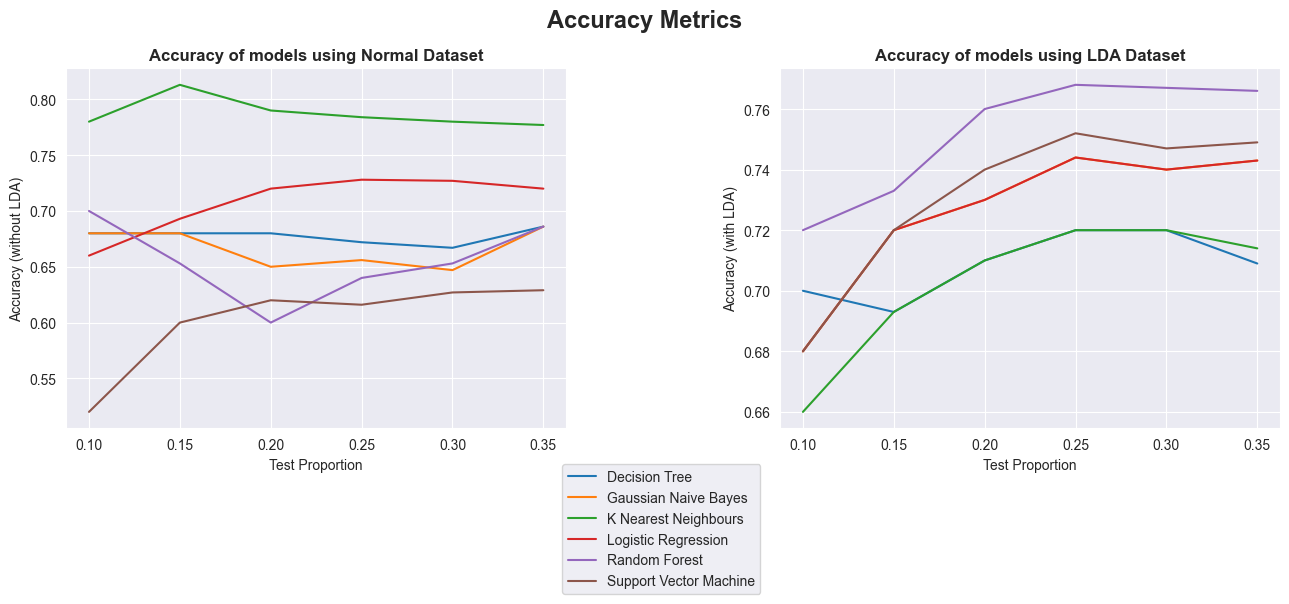

In [22]:
fig = plt.figure(figsize=(13,7))

# Normal dataset accuracy plot
plt.subplot(1,2,1)
sns.lineplot(data=ml_metrics, x='Test Proportion', y='Accuracy (without LDA)', hue='Classifier',legend=False)
plt.title("Accuracy of models using Normal Dataset", fontweight='bold')
# plt.legend(bbox_to_anchor=(1,1))

# LDA dataset accuracy plot
plt.subplot(1,2,2)
sns.lineplot(data=ml_metrics, x='Test Proportion', y='Accuracy (with LDA)', hue='Classifier')
plt.title("Accuracy of models using LDA Dataset", fontweight='bold')
plt.legend(bbox_to_anchor=(-0.45,-0.48), loc='lower left')

# fig.legend()
fig.suptitle("Accuracy Metrics", fontweight='bold', fontsize=17)
fig.tight_layout()
plt.show()

### Finding best test_size proportion for each Machine Learning model

In [76]:
clfs = ["Logistic Regression", "Support Vector Machine", "Gaussian Naive Bayes", "K Nearest Neighbours", "Decision Tree", "Random Forest"]
acc_types = ["Accuracy (without LDA)", "Accuracy (with LDA)"]

best_indices = []
ind_counter = 0
for clf in clfs:
    for acc_type in acc_types:
        # Finding index of row with best accuracy
        index = ml_metrics[ml_metrics.Classifier==clf][acc_type].idxmax()
        best_indices.append(index)

best_ml_metrics = ml_metrics.loc[best_indices].copy().reset_index(drop=True)
best_ml_metrics

,Classifier,Test Proportion,Accuracy (without LDA),Confusion Matrix (without LDA),Accuracy (with LDA),Confusion Matrix (with LDA)
0,Logistic Regression,0.25,0.728,"[[18, 30], [4, 73]]",0.744,"[[18, 30], [2, 75]]"
1,Logistic Regression,0.25,0.728,"[[18, 30], [4, 73]]",0.744,"[[18, 30], [2, 75]]"
2,Support Vector Machine,0.35,0.629,"[[0, 65], [0, 110]]",0.749,"[[23, 42], [2, 108]]"
3,Support Vector Machine,0.25,0.616,"[[0, 48], [0, 77]]",0.752,"[[19, 29], [2, 75]]"
4,Gaussian Naive Bayes,0.35,0.686,"[[43, 22], [33, 77]]",0.743,"[[22, 43], [2, 108]]"
5,Gaussian Naive Bayes,0.25,0.656,"[[32, 16], [27, 50]]",0.744,"[[18, 30], [2, 75]]"
6,K Nearest Neighbours,0.15,0.813,"[[17, 13], [1, 44]]",0.693,"[[9, 21], [2, 43]]"
7,K Nearest Neighbours,0.25,0.784,"[[28, 20], [7, 70]]",0.720,"[[15, 33], [2, 75]]"
8,Decision Tree,0.35,0.686,"[[24, 41], [14, 96]]",0.709,"[[19, 46], [5, 105]]"
9,Decision Tree,0.25,0.672,"[[22, 26], [15, 62]]",0.720,"[[17, 31], [4, 73]]"


The above table contains the best metrics for each type of Classifier, where the first entry is the highest accuracy obtained with a Test Proportion without applying LDA to the dataset and the second entry is the highest accuracy obtained with a Test Proportion after applying LDA to the dataset.

<hr>

## CNN

### Importing CNN libraries

In [23]:
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

### Resizing images and creating batches

In [24]:
train_datagen = ImageDataGenerator(rescale=1/255, shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory(
        directory = train_dir,
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        directory = test_dir,
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Creating validation data

In [25]:
validation = ImageDataGenerator(rescale=1./255)
vall = test_datagen.flow_from_directory(
        directory = data_dir / 'val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 16 images belonging to 2 classes.


### Creating Convolution model with 3 layers

In [26]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(.5))

cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#### Programming early stop

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, mode='min')

### Fitting CNN model

In [28]:
cnn_results = cnn_model.fit(training_set, epochs=10, validation_data=test_set) #, callbacks=early_stop)

Epoch 1/10
163/163 [==============================] - 104s 633ms/step - loss: 0.4766 - accuracy: 0.7870 - val_loss: 0.4093 - val_accuracy: 0.8173
Epoch 2/10
163/163 [==============================] - 55s 339ms/step - loss: 0.2788 - accuracy: 0.8813 - val_loss: 0.3572 - val_accuracy: 0.8446
Epoch 3/10
163/163 [==============================] - 55s 336ms/step - loss: 0.2207 - accuracy: 0.9078 - val_loss: 0.4840 - val_accuracy: 0.8349
Epoch 4/10
163/163 [==============================] - 55s 339ms/step - loss: 0.1981 - accuracy: 0.9248 - val_loss: 0.3961 - val_accuracy: 0.8574
Epoch 5/10
163/163 [==============================] - 55s 335ms/step - loss: 0.1874 - accuracy: 0.9270 - val_loss: 0.3835 - val_accuracy: 0.8558
Epoch 6/10
163/163 [==============================] - 55s 338ms/step - loss: 0.1845 - accuracy: 0.9317 - val_loss: 0.2603 - val_accuracy: 0.9054
Epoch 7/10
163/163 [==============================] - 55s 337ms/step - loss: 0.1725 - accuracy: 0.9323 - val_loss: 0.4153 - val_a

### Creating functions to Export accuracy and loss metrics and Visualize the data

In [29]:
def get_metrics(history):
    metrics = pd.DataFrame(history)
    metrics['Epoch'] = [x for x in range(len(metrics))]
    metrics = metrics[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]
    return metrics


def visualize_metrics(metrics, model):
    fig = plt.figure(figsize=(13,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    sns.lineplot(data=metrics, x='Epoch', y='accuracy', label='train_accuracy')
    sns.lineplot(data=metrics, x='Epoch', y='val_accuracy', label='val_accuracy')

    plt.title("Accuracy versus Epoch", fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower left')

    # Loss plot
    plt.subplot(1,2,2)
    sns.lineplot(data=metrics, x='Epoch', y='loss', label='train_loss')
    sns.lineplot(data=metrics, x='Epoch', y='val_loss', label='val_loss')

    plt.title('Model Loss', fontweight='bold')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left')

    fig.suptitle(f"Comparing Accuracy and Loss in {model}", fontweight='bold', fontsize=17)
    plt.show()

### Visualizing CNN results

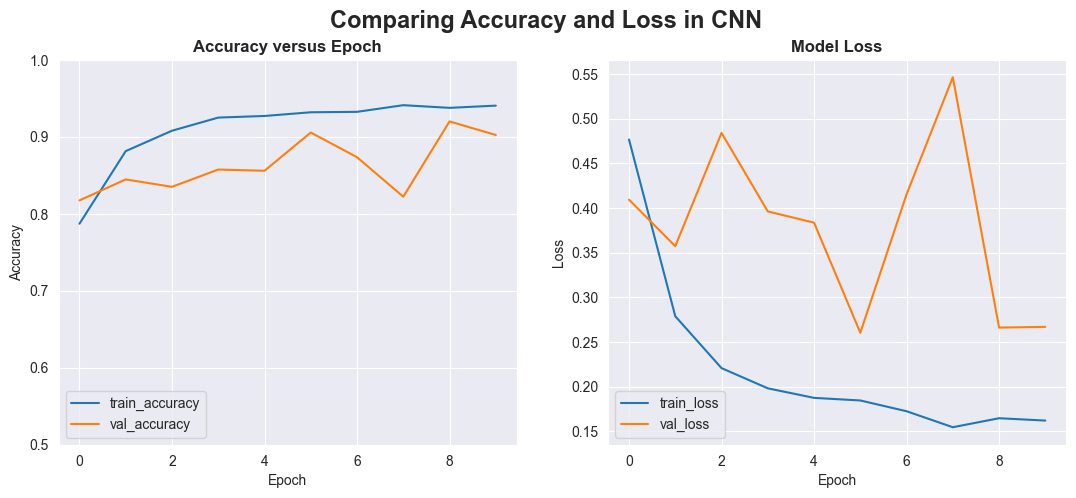

In [30]:
cnn_metrics = get_metrics(cnn_results.history)

visualize_metrics(cnn_metrics, "CNN")

#### Exporting CNN metrics to external csv file

In [31]:
cnn_metrics.to_csv("CNN_Metrics.csv", index=False)

### Evaluating CNN model

#### Creating function to evaluate the fitted model

In [32]:
def model_evaluation(model, name):
    print(f"Accuracy of {name} model:\n")
    evaluation = model.evaluate(test_set)
    print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")
    evaluation = model.evaluate(training_set)
    print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

#### Evaluating fitted CNN model

In [33]:
model_evaluation(cnn_model, "CNN")

Accuracy of CNN model:

20/20 [==============================] - 4s 216ms/step - loss: 0.2669 - accuracy: 0.9022
Test Accuracy: 90.22%
163/163 [==============================] - 42s 258ms/step - loss: 0.1733 - accuracy: 0.9287
Train Accuracy: 92.87%


<hr>

# VGG16

### Importing VGG16 libraries

In [34]:
from keras.models import Sequential
from keras.layers import AveragePooling2D, Flatten
from keras.applications import VGG16

### Creating VGG16 model

In [35]:
# we are passing paramers as following
# 1 weights='imagenet' - Using this we are carrying weights as of original weights.
# 2 we want to change the last layer so we are not including top layer
vgg16_base_model = VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

vgg16_model = Sequential([
        vgg16_base_model,
        AveragePooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.6),
        Dense(1, activation="sigmoid")
    ])

### Displaying model summary

In [36]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

### Compiling model

In [37]:
vgg16_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fitting VGG16 model

In [38]:
vgg_results = vgg16_model.fit(training_set, epochs=10, validation_data=test_set) #, callbacks=early_stop)

Epoch 1/10
163/163 [==============================] - 356s 2s/step - loss: 0.6358 - accuracy: 0.7243 - val_loss: 0.5927 - val_accuracy: 0.6346
Epoch 2/10
163/163 [==============================] - 353s 2s/step - loss: 0.4573 - accuracy: 0.7820 - val_loss: 0.5729 - val_accuracy: 0.7244
Epoch 3/10
163/163 [==============================] - 330s 2s/step - loss: 0.4279 - accuracy: 0.8092 - val_loss: 0.5691 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 326s 2s/step - loss: 0.4527 - accuracy: 0.7926 - val_loss: 0.6248 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 324s 2s/step - loss: 0.5753 - accuracy: 0.7674 - val_loss: 0.7600 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 324s 2s/step - loss: 0.5663 - accuracy: 0.7396 - val_loss: 0.6302 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 324s 2s/step - loss: 0.5801 - accuracy: 0.7419 - val_loss: 0.7006 - val_accuracy: 0.6250

### Visualizing VGG16 results

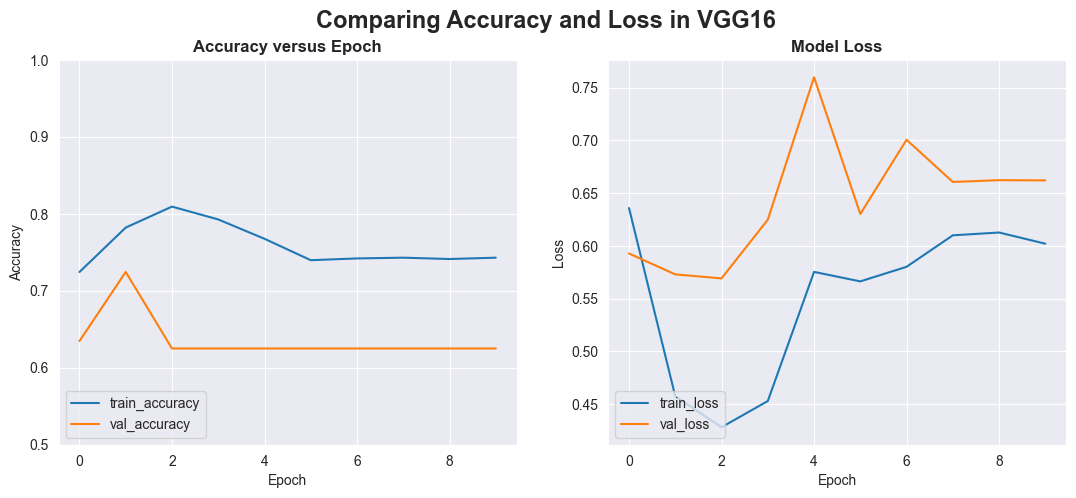

In [39]:
vgg_metrics = get_metrics(vgg_results.history)

visualize_metrics(vgg_metrics, "VGG16")

#### Exporting VGG16 metrics to external csv file

In [40]:
vgg_metrics.to_csv("VGG16_Metrics.csv", index=False)

### Evaluating VGG16 model

In [41]:
model_evaluation(vgg16_model, "VGG16")

Accuracy of VGG16 model:

20/20 [==============================] - 8s 413ms/step - loss: 0.6621 - accuracy: 0.6250
Test Accuracy: 62.50%
163/163 [==============================] - 75s 462ms/step - loss: 0.5940 - accuracy: 0.7429
Train Accuracy: 74.29%


<hr>

# Resnet

### Importing Resnet library

In [42]:
from keras.applications import ResNet50

### Creating Resnet model

In [51]:
resnet_base_model = ResNet50(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

resnet_model = Sequential([
        vgg16_base_model,
        AveragePooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.6),
        Dense(1, activation="sigmoid")
    ])

### Displaying model summary

In [52]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 average_pooling2d_3 (Averag  (None, 1, 1, 512)        0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                      

### Compiling model

In [53]:
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fitting Resnet model

In [54]:
resnet_results = resnet_model.fit(training_set, epochs=10, validation_data=test_set) #, callbacks=early_stop)

Epoch 1/10
163/163 [==============================] - 381s 2s/step - loss: 0.6105 - accuracy: 0.7814 - val_loss: 0.3804 - val_accuracy: 0.8285
Epoch 2/10
 56/163 [=========>....................] - ETA: 3:50 - loss: 0.2967 - accuracy: 0.8705

KeyboardInterrupt: 

### Visualizing Resnet results

In [ ]:
resnet_metrics = get_metrics(resnet_results.history)

visualize_metrics(resnet_metrics, "Resnet")

#### Exporting Resnet metrics to external csv file

In [ ]:
resnet_metrics.to_csv("Resnet_Metrics.csv", index=False)

### Evaluating Resnet model

In [ ]:
model_evaluation(resnet_model, "Resnet")

<hr>